In [1]:
import os
import ast
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["font.sans-serif"]=["WenQuanYi Micro Hei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题

# 禁止随机，结果可复现
random.seed(42)
np.random.seed(42)

## 超参数选择

In [2]:
# Parameters
emo_index_id = 0
stage_id = 0
model_id = 0
data_number = 20

In [3]:
# Parameters
emo_index_id = 2
stage_id = 0
model_id = 5
data_number = 100


In [4]:
emo_index = ['上证综合情绪值', '沪深300情绪值', '创业板情绪值'][emo_index_id]
stage = ['计算矩阵', '读取矩阵'][stage_id]
model = ['Emo-Dict/DLUT', 'Emo-Dict/Bian', 'Emo-Dict/Jiang',
         'Machine-learning/LR', 'Machine-learning/RF', 'Machine-learning/SVM', 
         'Deep-learning/Separated_task'][model_id]

ROOT_PATH = '/data/public/fintechlab/zdh/Individual-Stock-Analysis/B_Temporal_Clustering'
Clustering_Method = 'Clustering_Based_on_Separation'
Emotion_Data_PATH = f'{ROOT_PATH}/data/Emotion_Data/{model}'   # 情绪数据路径
Financial_Data_PATH = f'{ROOT_PATH}/data/Financial_Data' # 金融数据路径

print(f"Running with: emo_index={emo_index}, stage={stage}, model={model}, data_number={data_number}")

Running with: emo_index=创业板情绪值, stage=计算矩阵, model=Machine-learning/SVM, data_number=100


## 数据准备

In [5]:
"""读取股吧个股的数据"""
all_data = []
file_list = [f for f in os.listdir(Emotion_Data_PATH) if f.endswith('.csv')]

for file in file_list:
    file_path = os.path.join(Emotion_Data_PATH, file)
    df = pd.read_csv(file_path)
    stock_code = os.path.splitext(file)[0] # 获取股票编号（文件名去掉扩展名）
    
    # 提取每一行的日期和情绪值
    for _, row in df.iterrows():
        new_row = {
            '股票编号': stock_code,
            '日期': row['日期'],
            '上证综合情绪值': row['上证综合情绪值'],
            '沪深300情绪值': row['沪深300情绪值'],
            '创业板情绪值': row['创业板情绪值']
        }
        all_data.append(new_row)
        
guba_data = pd.DataFrame(all_data)
guba_data

,股票编号,日期,上证综合情绪值,沪深300情绪值,创业板情绪值
0,601933,2024-12-27,0.048365,0.028544,-0.006138
1,601933,2024-11-18,-0.242671,-0.338993,-0.460030
2,601933,2024-11-17,-0.031017,-0.009014,-0.180763
3,601933,2024-11-17,-0.167612,-0.170838,-0.367941
4,601933,2024-11-17,-0.167612,-0.170838,-0.367941
...,...,...,...,...,...
495326,601919,2021-04-09,-0.167612,-0.170838,-0.367941
495327,601919,2021-04-09,-0.167612,-0.170838,-0.367941
495328,601919,2021-04-08,-0.107420,-0.136616,-0.261801
495329,601919,2021-04-08,-0.054551,-0.103612,-0.128968


In [6]:
"""读取股票回报率的数据"""
return_data = pd.read_csv(f'{Financial_Data_PATH}/日个股回报率.csv', dtype={'股票编号': str})
return_data

,股票编号,日期,交易量,收益率变化
0,000002,2021-06-01,60990961,-0.003745
1,000002,2021-06-02,85354506,0.006015
2,000002,2021-06-03,50594187,-0.003363
3,000002,2021-06-04,71422364,-0.012748
4,000002,2021-06-07,64745280,-0.014812
...,...,...,...,...
154877,688981,2024-11-20,58507495,-0.017071
154878,688981,2024-11-21,56197106,0.002358
154879,688981,2024-11-22,79240108,-0.050588
154880,688981,2024-11-25,76905909,-0.029402


In [7]:
# 进行左连接，guba_data 为主表
merged_data = pd.merge(guba_data, return_data[['股票编号', '日期', '交易量', '收益率变化']], 
                       on=['股票编号', '日期'], 
                       how='left')
merged_data = merged_data.dropna()
merged_data

,股票编号,日期,上证综合情绪值,沪深300情绪值,创业板情绪值,交易量,收益率变化
1,601933,2024-11-18,-0.242671,-0.338993,-0.460030,310012824.0,-0.004608
11,601933,2024-11-15,-0.167612,-0.170838,-0.367941,423271473.0,-0.064655
12,601933,2024-11-15,-0.167612,-0.170838,-0.367941,423271473.0,-0.064655
13,601933,2024-11-14,-0.167612,-0.170838,-0.367941,372259052.0,-0.053061
14,601933,2024-11-14,-0.167612,-0.170838,-0.367941,372259052.0,-0.053061
...,...,...,...,...,...,...,...
495148,601919,2021-06-01,-0.167612,-0.170838,-0.367941,268816321.0,0.045859
495149,601919,2021-06-01,-0.120769,-0.159457,-0.308475,268816321.0,0.045859
495150,601919,2021-06-01,-0.029216,-0.077231,-0.073883,268816321.0,0.045859
495151,601919,2021-06-01,-0.309000,-0.368095,-0.376385,268816321.0,0.045859


## 数据预处理

In [8]:
# Step 1: 对情绪值列进行 Min-Max 标准化
def min_max_normalization(df, cols):
    for col in cols:
        min_val = df[col].min()
        max_val = df[col].max()
        df[col] = 2 * (df[col] - min_val) / (max_val - min_val) - 1
    return df

# Step 2: 对每个股票编号的数据进行标准化和按日期汇总
def process_data(df):
    df_processed = pd.DataFrame()  # 用于存储结果
    for stock_code, stock_data in df.groupby('股票编号'):
        # 对每个股票编号内的数据进行标准化
        stock_data = min_max_normalization(stock_data, ['上证综合情绪值', '沪深300情绪值', '创业板情绪值'])
        
        # 按日期汇总数据，同时保留股票编号
        stock_summary = stock_data.groupby('日期').agg({
            '股票编号': 'first',  # 保留股票编号（在同一日期内它是相同的，使用 'first'）
            '上证综合情绪值': 'mean',  # 上证综合情绪值按日期取均值
            '沪深300情绪值': 'mean',  # 沪深300情绪值按日期取均值
            '创业板情绪值': 'mean',  # 创业板情绪值按日期取均值
            '交易量': 'mean',  # 交易量按日期求和
            '收益率变化': 'mean'  # 收益率变化按日期取均值
        }).reset_index(drop=False)
        
        df_processed = pd.concat([df_processed, stock_summary], ignore_index=True)
    
    return df_processed

# 调用处理函数
final_data = process_data(merged_data)
final_data

,日期,股票编号,上证综合情绪值,沪深300情绪值,创业板情绪值,交易量,收益率变化
0,2021-06-01,000002,0.680410,0.627242,0.493338,60990961.0,-0.003745
1,2021-06-08,000002,0.658871,0.597697,0.448880,44676494.0,0.004626
2,2021-06-10,000002,0.686813,0.637801,0.503702,53800776.0,-0.010035
3,2021-06-11,000002,0.680410,0.627242,0.493338,75853738.0,-0.014035
4,2021-06-15,000002,0.677162,0.621400,0.473099,89915501.0,-0.020957
...,...,...,...,...,...,...,...
85724,2024-11-12,688981,0.522285,0.447128,0.459594,108866759.0,-0.036864
85725,2024-11-13,688981,0.520579,0.447234,0.461487,80759477.0,-0.019484
85726,2024-11-14,688981,0.497081,0.420732,0.431448,76194102.0,-0.022897
85727,2024-11-15,688981,0.513551,0.439638,0.450697,71066743.0,-0.020233


## DTW 聚类

In [9]:
# 选择需要的列
dtw_df = final_data[['日期', '股票编号', emo_index, '收益率变化']]

# 按照股票编号和日期排序
dtw_df = dtw_df.sort_values(by=['股票编号', '日期'])

# 创建一个以股票编号为键，日期为时间序列的字典
stock_data = {}
if data_number > len(dtw_df['股票编号'].unique()):
    data_number = len(dtw_df['股票编号'].unique())
for stock in dtw_df['股票编号'].unique()[:data_number]:
    stock_data[stock] = dtw_df[dtw_df['股票编号'] == stock][['日期', emo_index, '收益率变化']].reset_index(drop=True)

In [10]:
if stage == '计算矩阵':
    from tqdm import tqdm
    from fastdtw import fastdtw
    from scipy.spatial.distance import euclidean
    
    # 假设stock_data已经准备好了，stock_ids包含所有股票编号
    stock_ids = list(stock_data.keys())
    dtw_distances = np.zeros((len(stock_ids), len(stock_ids)))
    
    # 使用 tqdm 包装外层循环以显示进度条
    for i, stock_i in tqdm(enumerate(stock_ids), total=len(stock_ids), desc="计算 DTW 距离", unit="股票"):
        for j, stock_j in enumerate(stock_ids):
            if i < j:
                series_i = stock_data[stock_i][[emo_index, '收益率变化']].values
                series_j = stock_data[stock_j][[emo_index, '收益率变化']].values
                distance, _ = fastdtw(series_i, series_j, dist=euclidean)
                dtw_distances[i, j] = distance
                dtw_distances[j, i] = distance  # 对称距离矩阵
    
    
    if emo_index == '上证综合情绪值':
        print(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_上证综合')
        os.makedirs(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_上证综合', exist_ok=True)
        np.save(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{model}/个股分析_上证综合/dtw_distances.npy', dtw_distances)
    if emo_index == '沪深300情绪值':
        os.makedirs(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_沪深300', exist_ok=True)
        np.save(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_沪深300/dtw_distances.npy', dtw_distances)
    if emo_index == '创业板情绪值':
        os.makedirs(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_创业板', exist_ok=True)
        np.save(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_创业板/dtw_distances.npy', dtw_distances)

计算 DTW 距离:   0%|          | 0/100 [00:00<?, ?股票/s]

计算 DTW 距离:   1%|          | 1/100 [00:09<15:19,  9.29s/股票]

计算 DTW 距离:   2%|▏         | 2/100 [00:13<10:21,  6.34s/股票]

计算 DTW 距离:   3%|▎         | 3/100 [00:22<11:51,  7.33s/股票]

计算 DTW 距离:   4%|▍         | 4/100 [00:27<10:39,  6.67s/股票]

计算 DTW 距离:   5%|▌         | 5/100 [00:35<11:15,  7.11s/股票]

计算 DTW 距离:   6%|▌         | 6/100 [00:43<11:31,  7.36s/股票]

计算 DTW 距离:   7%|▋         | 7/100 [00:49<10:29,  6.77s/股票]

计算 DTW 距离:   8%|▊         | 8/100 [00:58<11:29,  7.50s/股票]

计算 DTW 距离:   9%|▉         | 9/100 [01:06<11:56,  7.87s/股票]

计算 DTW 距离:  10%|█         | 10/100 [01:13<11:26,  7.63s/股票]

计算 DTW 距离:  11%|█         | 11/100 [01:19<10:30,  7.08s/股票]

计算 DTW 距离:  12%|█▏        | 12/100 [01:26<10:21,  7.06s/股票]

计算 DTW 距离:  13%|█▎        | 13/100 [01:34<10:21,  7.15s/股票]

计算 DTW 距离:  14%|█▍        | 14/100 [01:41<10:14,  7.15s/股票]

计算 DTW 距离:  15%|█▌        | 15/100 [01:45<09:01,  6.37s/股票]

计算 DTW 距离:  16%|█▌        | 16/100 [01:49<07:39,  5.47s/股票]

计算 DTW 距离:  17%|█▋        | 17/100 [01:53<07:17,  5.27s/股票]

计算 DTW 距离:  18%|█▊        | 18/100 [01:58<06:50,  5.00s/股票]

计算 DTW 距离:  19%|█▉        | 19/100 [02:03<06:47,  5.03s/股票]

计算 DTW 距离:  20%|██        | 20/100 [02:08<06:43,  5.04s/股票]

计算 DTW 距离:  21%|██        | 21/100 [02:14<07:01,  5.33s/股票]

计算 DTW 距离:  22%|██▏       | 22/100 [02:19<06:50,  5.26s/股票]

计算 DTW 距离:  23%|██▎       | 23/100 [02:23<06:20,  4.94s/股票]

计算 DTW 距离:  24%|██▍       | 24/100 [02:28<06:08,  4.84s/股票]

计算 DTW 距离:  25%|██▌       | 25/100 [02:34<06:38,  5.31s/股票]

计算 DTW 距离:  26%|██▌       | 26/100 [02:40<06:51,  5.57s/股票]

计算 DTW 距离:  27%|██▋       | 27/100 [02:46<06:43,  5.53s/股票]

计算 DTW 距离:  28%|██▊       | 28/100 [02:51<06:34,  5.48s/股票]

计算 DTW 距离:  29%|██▉       | 29/100 [02:55<05:56,  5.02s/股票]

计算 DTW 距离:  30%|███       | 30/100 [03:00<05:51,  5.02s/股票]

计算 DTW 距离:  31%|███       | 31/100 [03:04<05:19,  4.63s/股票]

计算 DTW 距离:  32%|███▏      | 32/100 [03:09<05:16,  4.65s/股票]

计算 DTW 距离:  33%|███▎      | 33/100 [03:14<05:24,  4.85s/股票]

计算 DTW 距离:  34%|███▍      | 34/100 [03:19<05:29,  5.00s/股票]

计算 DTW 距离:  35%|███▌      | 35/100 [03:24<05:19,  4.92s/股票]

计算 DTW 距离:  36%|███▌      | 36/100 [03:30<05:25,  5.09s/股票]

计算 DTW 距离:  37%|███▋      | 37/100 [03:33<04:43,  4.49s/股票]

计算 DTW 距离:  38%|███▊      | 38/100 [03:37<04:33,  4.41s/股票]

计算 DTW 距离:  39%|███▉      | 39/100 [03:41<04:15,  4.19s/股票]

计算 DTW 距离:  40%|████      | 40/100 [03:43<03:44,  3.74s/股票]

计算 DTW 距离:  41%|████      | 41/100 [03:47<03:49,  3.89s/股票]

计算 DTW 距离:  42%|████▏     | 42/100 [03:52<03:57,  4.10s/股票]

计算 DTW 距离:  43%|████▎     | 43/100 [03:55<03:42,  3.90s/股票]

计算 DTW 距离:  44%|████▍     | 44/100 [03:58<03:14,  3.47s/股票]

计算 DTW 距离:  45%|████▌     | 45/100 [04:03<03:29,  3.81s/股票]

计算 DTW 距离:  46%|████▌     | 46/100 [04:05<03:08,  3.50s/股票]

计算 DTW 距离:  47%|████▋     | 47/100 [04:09<03:05,  3.51s/股票]

计算 DTW 距离:  48%|████▊     | 48/100 [04:12<02:52,  3.33s/股票]

计算 DTW 距离:  49%|████▉     | 49/100 [04:14<02:39,  3.13s/股票]

计算 DTW 距离:  50%|█████     | 50/100 [04:18<02:46,  3.32s/股票]

计算 DTW 距离:  51%|█████     | 51/100 [04:21<02:39,  3.25s/股票]

计算 DTW 距离:  52%|█████▏    | 52/100 [04:25<02:39,  3.32s/股票]

计算 DTW 距离:  53%|█████▎    | 53/100 [04:26<02:13,  2.83s/股票]

计算 DTW 距离:  54%|█████▍    | 54/100 [04:28<01:59,  2.59s/股票]

计算 DTW 距离:  55%|█████▌    | 55/100 [04:30<01:44,  2.31s/股票]

计算 DTW 距离:  56%|█████▌    | 56/100 [04:32<01:37,  2.21s/股票]

计算 DTW 距离:  57%|█████▋    | 57/100 [04:35<01:37,  2.28s/股票]

计算 DTW 距离:  58%|█████▊    | 58/100 [04:36<01:30,  2.16s/股票]

计算 DTW 距离:  59%|█████▉    | 59/100 [04:38<01:25,  2.10s/股票]

计算 DTW 距离:  60%|██████    | 60/100 [04:41<01:25,  2.13s/股票]

计算 DTW 距离:  61%|██████    | 61/100 [04:42<01:19,  2.05s/股票]

计算 DTW 距离:  62%|██████▏   | 62/100 [04:44<01:11,  1.88s/股票]

计算 DTW 距离:  63%|██████▎   | 63/100 [04:46<01:07,  1.82s/股票]

计算 DTW 距离:  64%|██████▍   | 64/100 [04:48<01:10,  1.96s/股票]

计算 DTW 距离:  65%|██████▌   | 65/100 [04:51<01:18,  2.25s/股票]

计算 DTW 距离:  66%|██████▌   | 66/100 [04:53<01:15,  2.22s/股票]

计算 DTW 距离:  67%|██████▋   | 67/100 [04:55<01:12,  2.21s/股票]

计算 DTW 距离:  68%|██████▊   | 68/100 [04:56<01:01,  1.93s/股票]

计算 DTW 距离:  69%|██████▉   | 69/100 [04:58<01:00,  1.96s/股票]

计算 DTW 距离:  70%|███████   | 70/100 [05:00<00:58,  1.96s/股票]

计算 DTW 距离:  71%|███████   | 71/100 [05:02<00:54,  1.89s/股票]

计算 DTW 距离:  72%|███████▏  | 72/100 [05:04<00:51,  1.85s/股票]

计算 DTW 距离:  73%|███████▎  | 73/100 [05:06<00:49,  1.84s/股票]

计算 DTW 距离:  74%|███████▍  | 74/100 [05:07<00:44,  1.71s/股票]

计算 DTW 距离:  75%|███████▌  | 75/100 [05:09<00:42,  1.70s/股票]

计算 DTW 距离:  76%|███████▌  | 76/100 [05:10<00:38,  1.59s/股票]

计算 DTW 距离:  77%|███████▋  | 77/100 [05:11<00:34,  1.50s/股票]

计算 DTW 距离:  78%|███████▊  | 78/100 [05:13<00:35,  1.60s/股票]

计算 DTW 距离:  79%|███████▉  | 79/100 [05:14<00:30,  1.45s/股票]

计算 DTW 距离:  80%|████████  | 80/100 [05:16<00:29,  1.50s/股票]

计算 DTW 距离:  81%|████████  | 81/100 [05:17<00:28,  1.49s/股票]

计算 DTW 距离:  82%|████████▏ | 82/100 [05:19<00:26,  1.46s/股票]

计算 DTW 距离:  83%|████████▎ | 83/100 [05:20<00:23,  1.41s/股票]

计算 DTW 距离:  84%|████████▍ | 84/100 [05:21<00:20,  1.31s/股票]

计算 DTW 距离:  85%|████████▌ | 85/100 [05:22<00:19,  1.28s/股票]

计算 DTW 距离:  86%|████████▌ | 86/100 [05:24<00:17,  1.22s/股票]

计算 DTW 距离:  87%|████████▋ | 87/100 [05:24<00:13,  1.06s/股票]

计算 DTW 距离:  88%|████████▊ | 88/100 [05:25<00:12,  1.02s/股票]

计算 DTW 距离:  89%|████████▉ | 89/100 [05:26<00:10,  1.04股票/s]

计算 DTW 距离:  90%|█████████ | 90/100 [05:26<00:08,  1.19股票/s]

计算 DTW 距离:  91%|█████████ | 91/100 [05:27<00:06,  1.47股票/s]

计算 DTW 距离:  92%|█████████▏| 92/100 [05:27<00:04,  1.68股票/s]

计算 DTW 距离:  93%|█████████▎| 93/100 [05:28<00:04,  1.73股票/s]

计算 DTW 距离:  94%|█████████▍| 94/100 [05:28<00:03,  1.94股票/s]

计算 DTW 距离:  95%|█████████▌| 95/100 [05:28<00:02,  2.32股票/s]

计算 DTW 距离:  96%|█████████▌| 96/100 [05:29<00:01,  2.80股票/s]

计算 DTW 距离:  97%|█████████▋| 97/100 [05:29<00:00,  3.47股票/s]

计算 DTW 距离:  98%|█████████▊| 98/100 [05:29<00:00,  4.14股票/s]

计算 DTW 距离: 100%|██████████| 100/100 [05:29<00:00,  3.29s/股票]

In [11]:
# 读取 DTW 距离矩阵
stock_ids = list(stock_data.keys())
if emo_index == '上证综合情绪值':
    dtw_distances = np.load(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_上证综合/dtw_distances.npy')
if emo_index == '沪深300情绪值':
    dtw_distances = np.load(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_沪深300/dtw_distances.npy')
if emo_index == '创业板情绪值':
    dtw_distances = np.load(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_创业板/dtw_distances.npy')

In [12]:
from sklearn.cluster import KMeans

# KMeans 聚类
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(dtw_distances)

# 查看每个股票的聚类结果
stock_clusters = {stock_ids[i]: clusters[i] for i in range(len(stock_ids))}

# 创建一个 DataFrame 来保存股票编号与对应的聚类标签
stock_clusters_df = pd.DataFrame({
    '股票编号': stock_ids,
    '聚类标签': clusters
})
if emo_index == '上证综合情绪值':
    stock_clusters_df.to_csv(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_上证综合/clusters_results.csv', index=False, encoding='utf-8')
if emo_index == '沪深300情绪值':
    stock_clusters_df.to_csv(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_沪深300/clusters_results.csv', index=False, encoding='utf-8')
if emo_index == '创业板情绪值':
    stock_clusters_df.to_csv(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_创业板/clusters_results.csv', index=False, encoding='utf-8')
stock_clusters


{'000002': np.int32(1),
 '000061': np.int32(0),
 '000063': np.int32(2),
 '000069': np.int32(0),
 '000100': np.int32(2),
 '000333': np.int32(2),
 '000513': np.int32(0),
 '000625': np.int32(2),
 '000651': np.int32(2),
 '000661': np.int32(0),
 '000681': np.int32(0),
 '000723': np.int32(2),
 '000725': np.int32(1),
 '000858': np.int32(1),
 '000895': np.int32(0),
 '000910': np.int32(0),
 '000937': np.int32(0),
 '000999': np.int32(2),
 '001979': np.int32(2),
 '002008': np.int32(0),
 '002024': np.int32(2),
 '002065': np.int32(2),
 '002142': np.int32(1),
 '002202': np.int32(0),
 '002230': np.int32(0),
 '002241': np.int32(1),
 '002271': np.int32(0),
 '002304': np.int32(2),
 '002368': np.int32(0),
 '002371': np.int32(0),
 '002387': np.int32(2),
 '002415': np.int32(0),
 '002460': np.int32(2),
 '002466': np.int32(2),
 '002475': np.int32(2),
 '002594': np.int32(1),
 '003816': np.int32(2),
 '300002': np.int32(0),
 '300003': np.int32(0),
 '300012': np.int32(2),
 '300014': np.int32(0),
 '300015': np.in

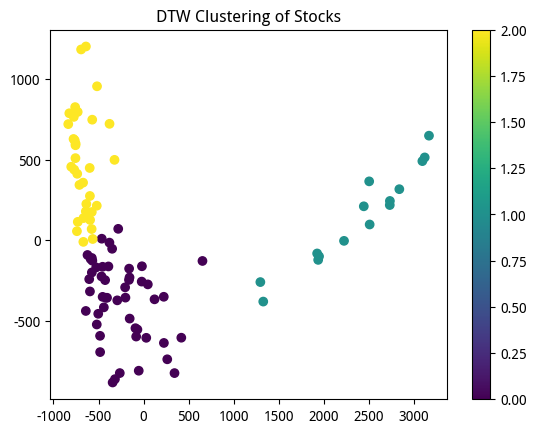

In [13]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 使用PCA将高维的DTW距离降到2D
pca = PCA(n_components=2)
dtw_distances_2d = pca.fit_transform(dtw_distances)

# 创建聚类结果的散点图
plt.scatter(dtw_distances_2d[:, 0], dtw_distances_2d[:, 1], c=clusters, cmap='viridis')
plt.colorbar()
plt.title('DTW Clustering of Stocks')
if emo_index == '上证综合情绪值':
    plt.savefig(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_上证综合/DTW_Clustering_of_Stocks3')
if emo_index == '沪深300情绪值':
    plt.savefig(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_沪深300/DTW_Clustering_of_Stocks3')
if emo_index == '创业板情绪值':
    plt.savefig(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_创业板/DTW_Clustering_of_Stocks3')
plt.show()


In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.dates as mdates

# 假设 final_data 已经加载并经过清洗处理
merged_data_cleaned = final_data.copy()

# 将日期列转换为 datetime 类型（确保时间格式正确）
merged_data_cleaned['日期'] = pd.to_datetime(merged_data_cleaned['日期'])

# 设置绘图窗口，一行三列的子图
fig, axes = plt.subplots(3, 1, figsize=(50, 50), subplot_kw={'projection': '3d'})

# 情绪值列名列表
emotion_columns = ['上证综合情绪值', '沪深300情绪值', '创业板情绪值']

# 遍历每个情绪值列
for i, emotion_col in enumerate(emotion_columns):
    ax = axes[i]
    
    # 按股票编号分组
    for stock_code, stock_data in merged_data_cleaned.groupby('股票编号'):
        if stock_code == '000002':  # 如果只关心股票编号为 '000002'
            # 对每个股票编号绘制三维折线图
            x = stock_data[emotion_col]  # 情绪值作为 x 轴
            y = mdates.date2num(stock_data['日期'])  # 时间转换为数值类型，用于 y 轴
            z = stock_data['收益率变化']  # 收益率变化作为 z 轴
            
            # 绘制三维折线图
            ax.plot(x, y, z, label=f"股票 {stock_code}", marker='o', linestyle='-', alpha=0.7)

    # 设置图表标签
    ax.set_xlabel(emotion_col)
    ax.set_ylabel('时间')
    ax.set_zlabel('收益率变化')
    ax.set_title(f'{emotion_col} 与收益率变化的三维关系')

    # 设置 y 轴显示为半年显示一次
    ax.yaxis.set_major_locator(mdates.MonthLocator(bymonthday=15, interval=6))  # 每半年一个刻度
    ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # 按年月显示

    # 自动旋转日期标签，防止重叠
    fig.autofmt_xdate()

# 调整布局
plt.tight_layout()
plt.savefig(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/万科A情绪股价时间序列数据')
# plt.show()
plt.close()

## 数据集成

In [15]:
import pandas as pd

# 读取两个CSV文件
if emo_index == '上证综合情绪值':
    cluster_df = pd.read_csv(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_上证综合/clusters_results.csv', dtype={'股票编号': str})
if emo_index == '沪深300情绪值':
    cluster_df = pd.read_csv(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_沪深300/clusters_results.csv', dtype={'股票编号': str})
if emo_index == '创业板情绪值':
    cluster_df = pd.read_csv(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_创业板/clusters_results.csv', dtype={'股票编号': str})
company_info_df = pd.read_csv(f'{Financial_Data_PATH}/中国公司代码.csv', dtype={'Stkcd': str})  # 假设第二个文件名为company_info.csv

# 重命名列名，统一为 'Stkcd' 以便合并
cluster_df = cluster_df.rename(columns={'股票编号': 'Stkcd'})

# 显式统一合并键的数据类型
cluster_df['Stkcd'] = cluster_df['Stkcd'].astype(str)
company_info_df['Stkcd'] = company_info_df['Stkcd'].astype(str)

# 合并前清除可能重复的列，防止冲突
if 'Stknme' in cluster_df.columns:
    cluster_df = cluster_df.drop(columns=['Stknme'])

# 安全合并
merged_df = pd.merge(cluster_df, company_info_df[['Stkcd', 'Stknme']], on='Stkcd', how='left')

if emo_index == '上证综合情绪值':
    merged_df.to_csv(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_上证综合/clusters_results.csv', index=False)
if emo_index == '沪深300情绪值':
    merged_df.to_csv(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_沪深300/clusters_results.csv', index=False)
if emo_index == '创业板情绪值':
    merged_df.to_csv(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_创业板/clusters_results.csv', index=False)

merged_df


,Stkcd,聚类标签,Stknme
0,000002,1,万科A
1,000061,0,农产品
2,000063,2,中兴通讯
3,000069,0,华侨城A
4,000100,2,TCL科技
...,...,...,...
95,600352,0,浙江龙盛
96,600406,0,国电南瑞
97,600438,1,通威股份
98,600483,0,福能股份
